# Introduction

Following is the dataset description, copied from the [Kaggle page](https://www.kaggle.com/mashlyn/online-retail-ii-uci).

*This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.*

**Attribute Information:**

- `InvoiceNo`: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- `StockCode`: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- `Description`: Product (item) name. Nominal.
- `Quantity`: The quantities of each product (item) per transaction. Numeric.
- `InvoiceDate`: Invice date and time. Numeric. The day and time when a transaction was generated.
- `UnitPrice`: Unit price. Numeric. Product price per unit in sterling (Â£).
- `CustomerID`: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- `Country`: Country name. Nominal. The name of the country where a customer resides.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_context('talk')

# Data Preparation

There are 1,067,371 records with eight columns. There are null values on `Description` and `Customer ID` columns.

In [2]:
df_raw = pd.read_csv("online_retail_II.csv")
df_raw.shape

(1067371, 8)

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


Before performing further analysis, we should determine the correct data type of the columns. For instance, `Customer ID` shouldn't be treated as numeric values.

We also create a new column called `subtotal`, which is the multiplication of `Quantity` and the unit price (`Price`).

In [4]:
df_raw['Customer ID'] = df_raw['Customer ID'].astype(str).apply(lambda x: x.split('.')[0])
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])
df_raw['subtotal'] = df_raw['Quantity'] * df_raw['Price']

Each record stores a pair of Invoice ID and a purchased item. Thus, there could be multiple records for one invoice.

In [5]:
df_raw.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,subtotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


# Exploratory Analysis

The dataset is not clean; we have negative values in `Quantity` and `Price`.

In [6]:
df_raw.describe()

,Quantity,Price,subtotal
count,1.067371e+06,1.067371e+06,1.067371e+06
mean,9.938898e+00,4.649388e+00,1.806987e+01
std,1.727058e+02,1.235531e+02,2.924202e+02
min,-8.099500e+04,-5.359436e+04,-1.684696e+05
25%,1.000000e+00,1.250000e+00,3.750000e+00
50%,3.000000e+00,2.100000e+00,9.900000e+00
75%,1.000000e+01,4.150000e+00,1.770000e+01
max,8.099500e+04,3.897000e+04,1.684696e+05


# Data Cleaning

We observe some records with negative price. Since there are only 5 records, we can remove them.

In [7]:
mask_neg_price = (df_raw['Price'] < 0)
print("Remove {} records with negative price.".format(df_raw[mask_neg_price].shape[0]))

df_raw = df_raw[~mask_neg_price].copy()

Remove 5 records with negative price.


There are more than 22,000 records with negative quantities. It can occur due to sales return or if the products are sold before the data collection date.

Despite the seemingly high number, it only represents 2.15% of our dataset. Moreover, it occurs in most of the months (except in January), with more occurrence around Q4 of the year. Assuming that it is distributed randomly over the period, we ignore these records from our dataset.

In [8]:
mask_neg_qty = (df_raw['Quantity'] < 0)

print("Records with negative quantity: {:,.0f} ~ {:,.2%} of the records.".format(
    df_raw[mask_neg_qty].shape[0],
      df_raw[mask_neg_qty].shape[0] / df_raw.shape[0]
     ))

Records with negative quantity: 22,950 ~ 2.15% of the records.


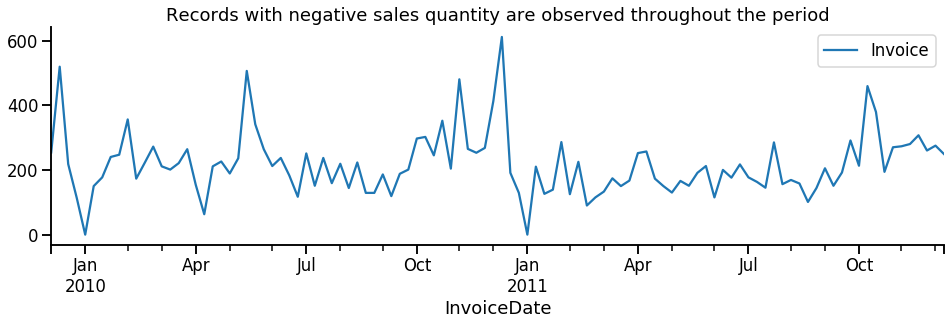

In [9]:
f, ax = plt.subplots(figsize = (16,4))
df_raw[mask_neg_qty].groupby(pd.Grouper(key = 'InvoiceDate', freq = '1W')).agg({
    'Invoice': 'count'
}).plot.line(ax = ax);

sns.despine();
plt.title("Records with negative sales quantity are observed throughout the period");
plt.show();

In [10]:
df_raw = df_raw[~mask_neg_qty].copy()
print("Remaining observations: {:,.0f}".format(df_raw.shape[0]))

Remaining observations: 1,044,416


## Model Training

Try using [scikit-hts](https://github.com/carlomazzaferro/scikit-hts)

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

def mean_absolute_percentage_error1(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((np.abs(y_true - y_pred) + 1) /(y_true + 1)) * 100

def weighted_ape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

def evaluate_prediction(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = (mean_absolute_error(y_true, y_pred))
    mape = (mean_absolute_percentage_error(y_true, y_pred))
    mape1 = (mean_absolute_percentage_error1(y_true, y_pred))
    wape = weighted_ape(y_true, y_pred)
    print("RMSE\t: {:,.5f}".format(rmse))
    print("MAE\t: {:,.5f}".format(mae))
    print("MAPE\t: {:,.2f}%".format(mape))
    print("MAPE1\t: {:,.2f}%".format(mape1))
    print("WAPE\t: {:,.2f}%".format(wape))

In [12]:
## TO DO: create features
## based on product hierarchy

## simplify: select top 5 countries 
## note that there is "unspecified" country as well
mask_country = df_raw['Country'].isin(['United Kingdom','EIRE','Germany','France','Spain'])
## simplify: select top 5 stock code
mask_stock = df_raw['StockCode'].isin(['85123A','85099B','22423','21212','20725'])
df_raw = df_raw[mask_country & mask_stock].copy().reset_index().drop(labels=['index'], axis=1)

In [13]:
# df_raw.groupby(['Country']).agg({'StockCode': pd.Series.nunique}).sort_values(by='StockCode', ascending=False)

In [14]:
df_raw.iloc[0]

Invoice                                    489442
StockCode                                  85123A
Description    WHITE HANGING HEART T-LIGHT HOLDER
Quantity                                        6
InvoiceDate                   2009-12-01 09:46:00
Price                                        2.95
Customer ID                                 13635
Country                            United Kingdom
subtotal                                     17.7
Name: 0, dtype: object

In [15]:
df_agg = df_raw.groupby([
    pd.Grouper(key='InvoiceDate', freq='1W'),
    'Country',
    'StockCode'
]).agg({
    'Quantity': 'sum'
}).reset_index()

df_agg_pivot = df_agg.pivot_table(
    index='InvoiceDate',
    columns=['Country','StockCode'],
    values='Quantity',
    fill_value=0,
    aggfunc='sum'
)

df_agg_pivot.columns = ['_'.join(col) for col in df_agg_pivot.columns]

df_agg_pivot['total'] = df_agg_pivot.sum(axis=1)

In [16]:
df_agg_pivot.head()

,EIRE_20725,EIRE_21212,EIRE_22423,EIRE_85099B,EIRE_85123A,France_20725,France_21212,France_22423,France_85099B,France_85123A,...,Spain_21212,Spain_22423,Spain_85099B,Spain_85123A,United Kingdom_20725,United Kingdom_21212,United Kingdom_22423,United Kingdom_85099B,United Kingdom_85123A,total
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2009-12-06,0,24,0,0,0,0,48,0,20,0,...,0,0,0,0,206,1360,0,1148,1353,4189
2009-12-13,0,24,0,0,108,0,24,0,0,18,...,0,0,0,0,314,1075,0,1233,3046,5842
2009-12-20,0,24,0,10,18,0,0,0,0,0,...,0,0,0,0,236,1567,0,1254,1258,4387
2009-12-27,100,240,0,0,0,0,0,0,0,0,...,0,0,20,0,11,524,0,16,128,1039
2010-01-10,0,480,0,300,184,30,84,0,140,0,...,0,0,0,12,294,207,0,712,1577,4020


In [17]:
from hts.hierarchy import HierarchyTree

uk_cols = ['United Kingdom'+'_'+stock for stock in ['85123A','85099B','22423','21212','20725']]
eire_cols = ['EIRE'+'_'+stock for stock in ['85123A','85099B','22423','21212','20725']]
germany_cols = ['Germany'+'_'+stock for stock in ['85123A','85099B','22423','21212','20725']]
france_cols = ['France'+'_'+stock for stock in ['85123A','85099B','22423','21212','20725']]
spain_cols = ['Spain'+'_'+stock for stock in ['85123A','85099B','22423','21212','20725']]

df_agg_pivot['United Kingdom'] = df_agg_pivot[uk_cols].sum(axis=1)
df_agg_pivot['EIRE'] = df_agg_pivot[eire_cols].sum(axis=1)
df_agg_pivot['Germany'] = df_agg_pivot[germany_cols].sum(axis=1)
df_agg_pivot['France'] = df_agg_pivot[france_cols].sum(axis=1)
df_agg_pivot['Spain'] = df_agg_pivot[spain_cols].sum(axis=1)

## to do: can we use multiindex as hierarchy structure?
hierarchy = {
    'total': ['United Kingdom', 'EIRE', 'Germany','France','Spain'], # uk_cols+eire_cols+germany_cols+france_cols+spain_cols,
    'United Kingdom': uk_cols,
    'EIRE': eire_cols,
    'Germany': germany_cols,
    'France': france_cols,
    'Spain': spain_cols
}

htree = HierarchyTree.from_nodes(hierarchy, df_agg_pivot)
htree

- total
   |- United Kingdom
   |  |- United Kingdom_85123A
   |  |- United Kingdom_85099B
   |  |- United Kingdom_22423
   |  |- United Kingdom_21212
   |  - United Kingdom_20725
   |- EIRE
   |  |- EIRE_85123A
   |  |- EIRE_85099B
   |  |- EIRE_22423
   |  |- EIRE_21212
   |  - EIRE_20725
   |- Germany
   |  |- Germany_85123A
   |  |- Germany_85099B
   |  |- Germany_22423
   |  |- Germany_21212
   |  - Germany_20725
   |- France
   |  |- France_85123A
   |  |- France_85099B
   |  |- France_22423
   |  |- France_21212
   |  - France_20725
   - Spain
      |- Spain_85123A
      |- Spain_85099B
      |- Spain_22423
      |- Spain_21212
      - Spain_20725

In [18]:
df_agg_pivot = df_agg_pivot.resample("W").sum()

In [19]:
TEST_START_DT = '2011-09-01'
TEST_END_DT = '2011-12-01'
mask_train = (df_agg_pivot.index < pd.to_datetime(TEST_START_DT))
mask_test = (
    (df_agg_pivot.index >= pd.to_datetime(TEST_START_DT)) & 
    (df_agg_pivot.index < pd.to_datetime(TEST_END_DT))
)

df_train = df_agg_pivot[mask_train].copy()
df_test = df_agg_pivot[mask_test].copy()

In [25]:
from hts import HTSRegressor

reg = HTSRegressor(model='prophet', revision_method='OLS', n_jobs=12)
reg.model_args = {
    'weekly_seasonality': True,
    'yearly_seasonality': True,
    'daily_seasonality': True
}
reg = reg.fit(df=df_agg_pivot, nodes=hierarchy)

preds = reg.predict(steps_ahead=3)

Fitting models: 100%|██████████| 31/31 [00:19<00:00,  1.62it/s]


In [26]:
df_combined = pd.DataFrame(df_agg_pivot['total'])
df_combined['type'] = 'actual'

_tmp = pd.DataFrame(preds['total'])
_tmp['type'] = 'pred'

df_combined = pd.concat([
    df_combined, 
    _tmp
])

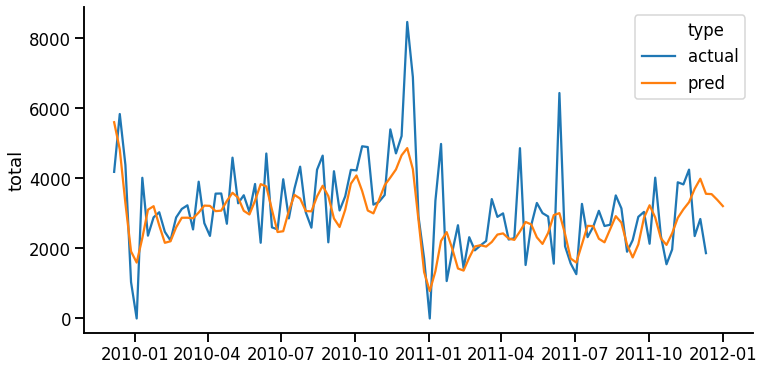

In [27]:
f, ax = plt.subplots(figsize=(12,6))

sns.lineplot(
    x=df_combined.index,
    y=df_combined['total'],
    hue=df_combined['type']
)
sns.despine();

In [32]:
evaluate_prediction(
    df_agg_pivot['total'],
    preds['total'][:-3]
)

RMSE	: 1,031.54596
MAE	: 760.58073
MAPE	: inf%
MAPE1	: 2,271.28%
WAPE	: 0.24%


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [24]:
## checkpoint